In [25]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the processed data
df = pd.read_csv('data/retail.csv')
print(df.shape)
print(df.dtypes)

(339702, 8)
InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [6]:
# Define CustomerID as categorical
df['CustomerID'] = pd.Categorical(df['CustomerID'].astype(int))
# Define StockCode as categorical
df['StockCode'] = pd.Categorical(df['StockCode'])
# Convert the InvoiceDate feature to a date/time type using Pandas to_datetime() function
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Drop the country column as all the data comes from a single country
df = df.drop(columns='Country')

In [8]:
print(df.shape)
print(df.dtypes)

(339702, 7)
InvoiceNo               int64
StockCode            category
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID           category
dtype: object


In [12]:
df['InvoiceDay'] = df.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
ref_date = max(df.InvoiceDay) + dt.timedelta(1)
df['TotalSum'] = df.Quantity * df.UnitPrice

In [14]:
# Calculate RFM
rfm = df.groupby('CustomerID').agg({
     'InvoiceNo':'count',
     'TotalSum':'sum',
     'InvoiceDay': lambda x: ref_date - x.max()})
# Rename columns
rfm.rename(columns={
     'InvoiceNo':'Frequency',
     'TotalSum':'Monetary',
     'InvoiceDay':'Recency'
 }, inplace=True)
rfm['Recency'] = rfm['Recency'].dt.days

/tmp/ipykernel_4061/2080448396.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm = df.groupby('CustomerID').agg({


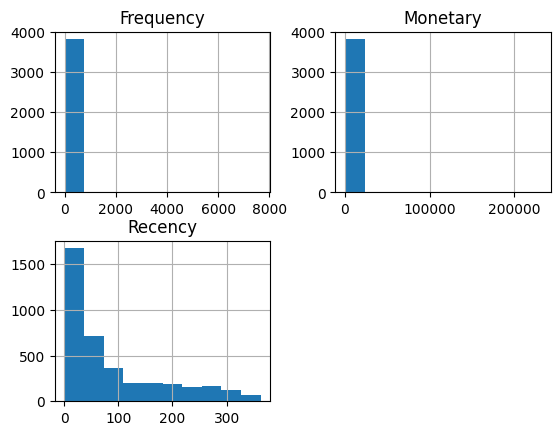

In [22]:
rfm.hist()
plt.show()

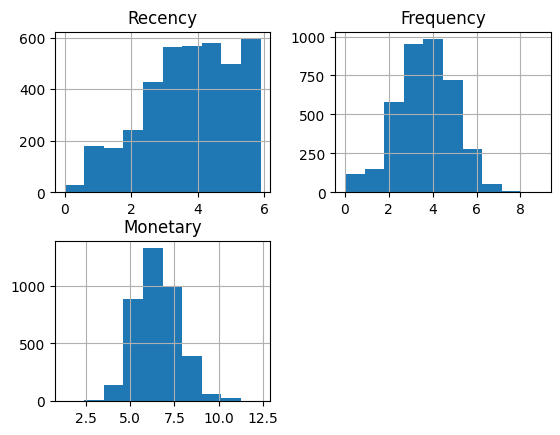

In [23]:
# Apply Log Transform
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1)
rfm_log.hist()
plt.show()

In [26]:
# Calculate the inertia values for various values of k
inertia = {}
for k in range(1,11):
    mod = KMeans(n_clusters=k)
    mod.fit(rfm_log)
    inertia[k] = mod.inertia_

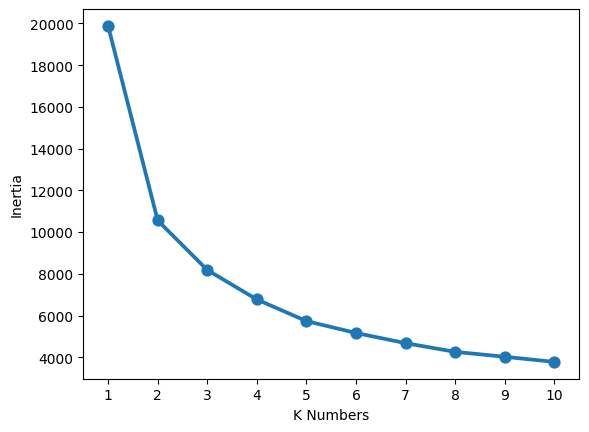

In [27]:
# Create an elbow plot to determine the best k
import seaborn as sns
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('Inertia')
plt.show()

In [32]:
mod = KMeans(n_clusters=3)
mod.fit(rfm_log)
rfm_log['cluster'] = mod.predict(rfm_log)
rfm_log.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,0
12747,1.098612,4.564348,8.252563,2
12748,0.000000,8.306719,10.318949,2
12749,1.386294,5.293305,8.316515,2
12820,1.386294,4.077537,6.848366,2


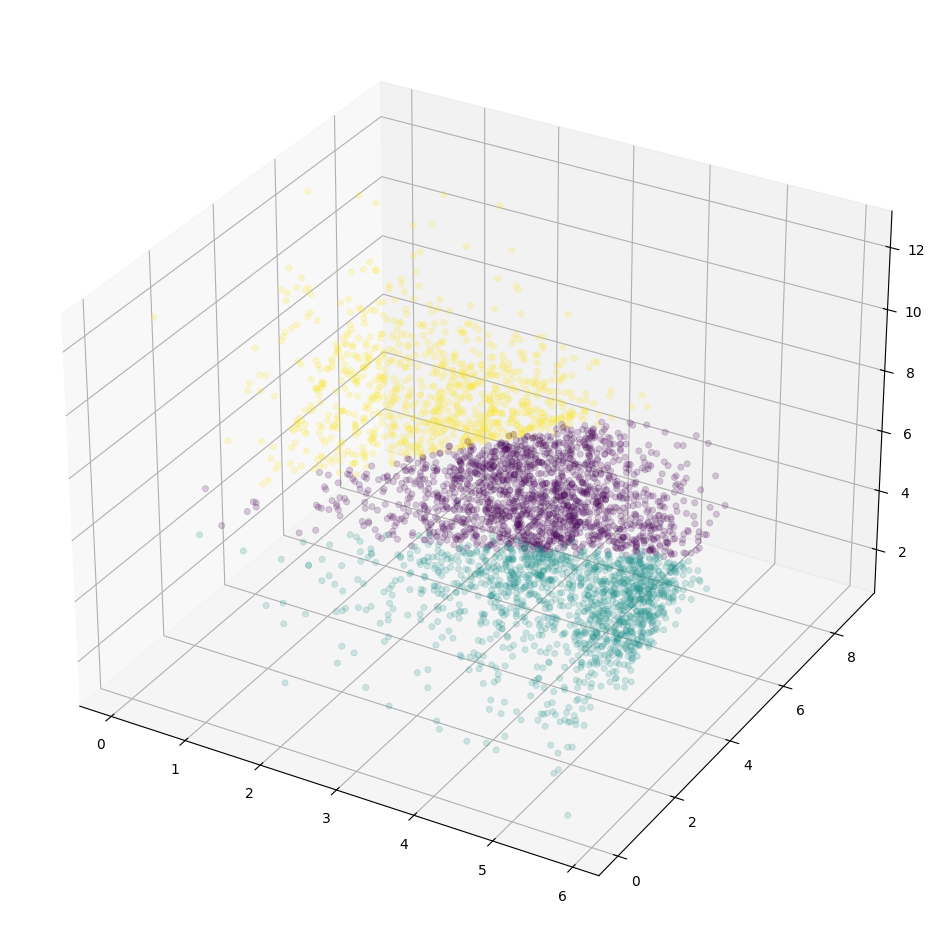

In [33]:
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(rfm_log.Recency, rfm_log.Frequency, 
                        rfm_log.Monetary, c=rfm_log.cluster,
                        cmap='viridis', linewidth=0.5, alpha=0.2);
plt.show()

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(rfm_log)
rfm_pca2 = pca.transform(rfm_log) 

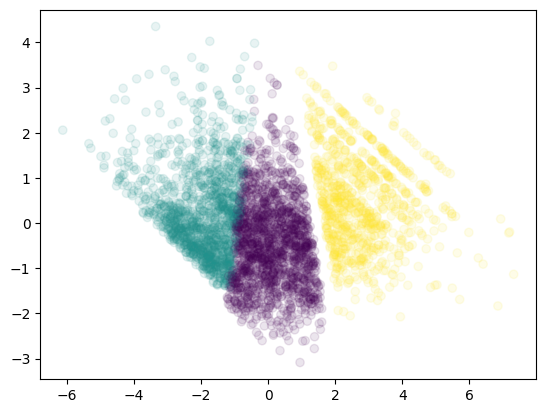

In [37]:
# Plot the data as a scatterplot
(x, y) = (rfm_pca2[:,0], rfm_pca2[:,1])
plt.scatter(x,y, c=rfm_log.cluster, alpha=0.1, cmap='viridis')
plt.show()

In [40]:
# Let's compare the centroid values
centroids_log = pd.DataFrame(mod.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
print(centroids_log)
# Convert these centroid values back to the original scale
centroids_orig = centroids_log[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1).round(3)
print(centroids_orig)

    Recency  Frequency  Monetary
0  3.826109   3.948253  6.695610
1  4.791159   2.335822  5.394128
2  2.063900   5.080340  7.945183
   Recency  Frequency  Monetary
0   45.884     51.845   808.847
1  120.441     10.338   220.110
2    7.877    160.829  2821.949


In [41]:
pd.DataFrame(mod.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary']).apply(np.exp, axis = 1).round(3)

,Recency,Frequency,Monetary
0,45.884,51.845,808.847
1,120.441,10.338,220.110
2,7.877,160.829,2821.949


In [46]:
# Extract only the small customers (high recency, low frequency, low monetary)
# Use the correct cluster id from the dataframe above as the cluster id will change from run to run
small_customers = rfm_log[rfm_log.cluster == 1] 
print(small_customers.shape)

(1330, 4)


In [43]:
# convert the values back to normal scale and display
small_customers = small_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
small_customers['Recency'] = np.rint(small_customers['Recency']).astype(int)
small_customers['Frequency'] = np.rint(small_customers['Frequency']).astype(int)
small_customers['Monetary'] = np.round(small_customers['Monetary'], 2)
print(small_customers.head())

            Recency  Frequency  Monetary
CustomerID                              
12821           215          6     92.72
12823            75          5   1759.50
12829           337         11    293.00
12831           263          9    215.05
12833           146         24    417.38


In [44]:
# Save the RFM for small customers
small_customers.to_csv('data/small_cust.csv')

In [47]:
# Similarly, extract the large customers, display and save
large_customers = rfm_log[rfm_log.cluster == 2] # Remember to check this id based in the labeled centroid dataframe above
print(large_customers.shape)

(875, 4)


In [48]:
large_customers = large_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
large_customers['Recency'] = np.rint(large_customers['Recency']).astype(int)
large_customers['Frequency'] = np.rint(large_customers['Frequency']).astype(int)
large_customers['Monetary'] = np.round(large_customers['Monetary'], 2)
print(large_customers.head())

            Recency  Frequency  Monetary
CustomerID                              
12747             3         96   3837.45
12748             1       4051  30301.40
12749             4        199   4090.88
12820             4         59    942.34
12826             3         82   1319.72


In [49]:
large_customers.to_csv('data/large_cust.csv')